<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Коннекция-к-базе,-открытие-файла" data-toc-modified-id="Коннекция-к-базе,-открытие-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Коннекция к базе, открытие файла</a></span></li><li><span><a href="#Знакомство-с-данными-и-предобработка" data-toc-modified-id="Знакомство-с-данными-и-предобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Знакомство с данными и предобработка</a></span></li><li><span><a href="#Экспорт-файла" data-toc-modified-id="Экспорт-файла-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Экспорт файла</a></span></li><li><span><a href="#Дашборд" data-toc-modified-id="Дашборд-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Дашборд</a></span></li><li><span><a href="#Выводы,-презентация" data-toc-modified-id="Выводы,-презентация-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы, презентация</a></span></li></ul></div>

# Автоматизация: дашборд для менеджеров Яндекс.Дзен

Для автоматизации работы менеджеров необходимо создать дашборд, отвечающийна регулярно возникающие вопросы:
* Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
* Как много карточек генерируют источники с разными темами?
* Как соотносятся темы карточек и темы источников?

**Согласованное с администраторами БД и менеджерами ТЗ:**
* Бизнес-задача: анализ взаимодействия пользователей с карточками Яндекс.Дзен;
* Насколько часто предполагается пользоваться дашбордом: не реже, чем раз в неделю;
* Основные пользователи дашборда: менеджеры по анализу контента;
* Состав данных для дашборда:
    * История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
    * Разбивка событий по темам источников;
    * Таблица соответствия тем источников темам карточек;
* По каким параметрам данные должны группироваться:
    * Дата и время;
    * Тема карточки;
    * Тема источника;
    * Возрастная группа;
* Характер данных:
    * История событий по темам карточек — абсолютные величины с разбивкой по минутам;
    * Разбивка событий по темам источников — относительные величины (% событий);
    * Соответствия тем источников темам карточек - абсолютные величины;
* Важность: все графики имеют равную важность;
* Источники данных для дашборда: агрегирующая таблица dash_visits со следующей структурой:
    * record_id — первичный ключ,
    * item_topic — тема карточки,
    * source_topic — тема источника,
    * age_segment — возрастной сегмент,
    * dt — дата и время,
    * visits — количество событий.
* Таблица хранится в базе данных zen;
* Частота обновления данных: один раз в сутки, в полночь по UTC;
* Макет дашборда:
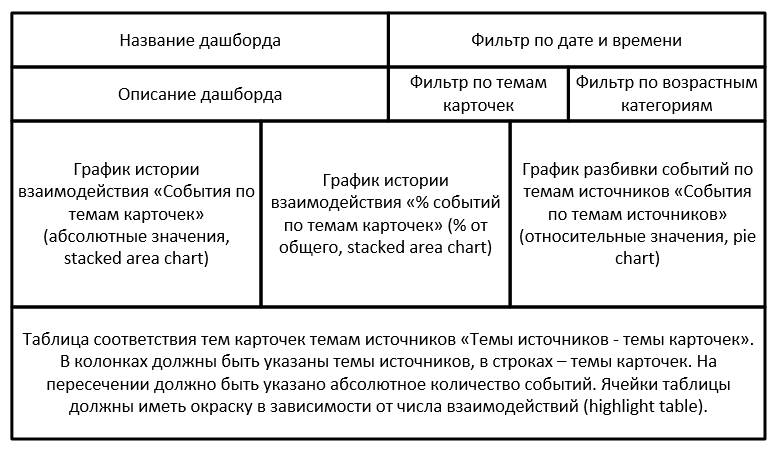

## Коннекция к базе, открытие файла

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
plt.style.use('ggplot')

db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string) 

In [2]:
query = ''' SELECT *
            FROM dash_visits
        '''
dash_visits = pd.io.sql.read_sql(query, con = engine) 
dash_visits.head(5)

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


## Знакомство с данными и предобработка

Проверим корректность данных в dash_visits

In [3]:
dash_visits.info()
print()
print('Число строк-дубликатов:', dash_visits.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB

Число строк-дубликатов: 0


Имеем 30745 наблюдений, пропусков и дубликатов нет, типы данных корректны. Посмотрим, какие данные хранятся в столбцах, удостоверимся, что все данные выгружены корректно.

**record_id**

In [4]:
# функция, выводит число уникальных значений в столбце
def uniq_count (col):
    return print('Количество уникальных значений в {col} : {uniq_count}'.format(col=col, uniq_count=len(dash_visits[col].unique())))

In [5]:
uniq_count('record_id')

Количество уникальных значений в record_id : 30745


Дубликатов в столбце с первичными ключами нет, все значения уникальны.

**item_topic**    

Количество уникальных значений в item_topic : 25


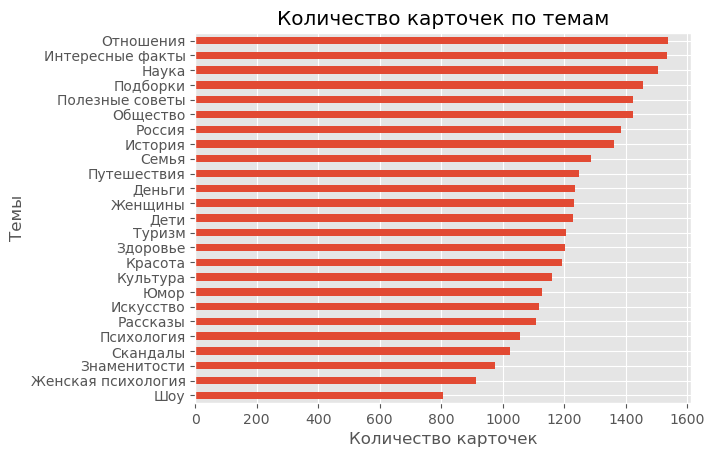

In [6]:
uniq_count('item_topic')
dash_visits['item_topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Количество карточек по темам')
plt.xlabel('Количество карточек')
plt.ylabel('Темы');

Встречается 25 уникальных тем карточек, данные распределены нормально.

**source_topic**

Количество уникальных значений в source_topic : 26


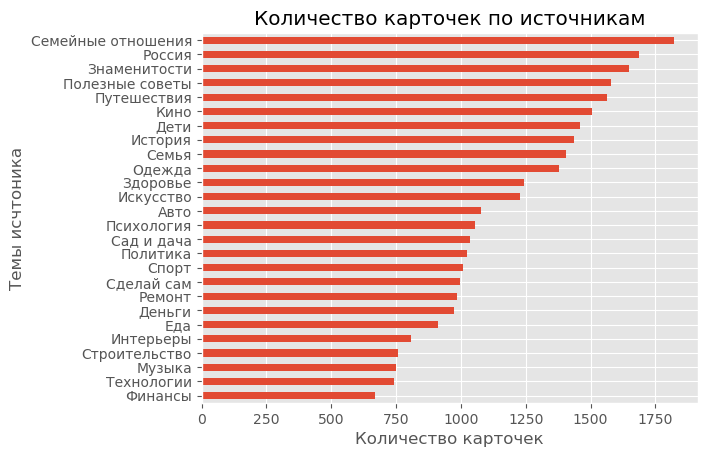

In [7]:
uniq_count('source_topic')
dash_visits['source_topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Количество карточек по источникам')
plt.xlabel('Количество карточек')
plt.ylabel('Темы исчтоника');

26 уникальных источников, данные распределны нормально.

**age_segment**

Количество уникальных значений в age_segment : 6


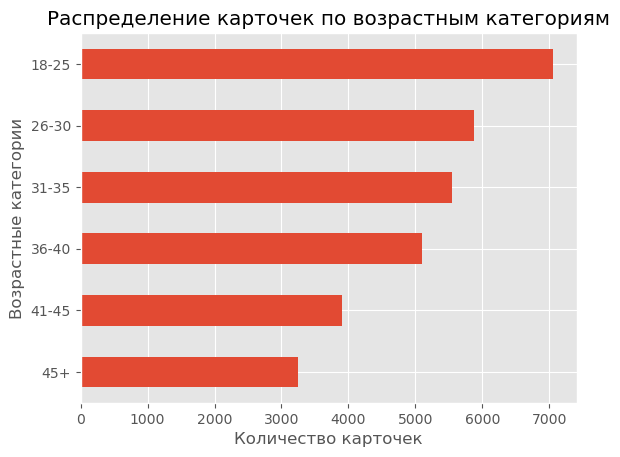

In [8]:
uniq_count('age_segment')
dash_visits['age_segment'].value_counts().sort_values().plot(kind='barh')
plt.title('Распределение карточек по возрастным категориям')
plt.xlabel('Количество карточек')
plt.ylabel('Возрастные категории');

6 типов возрастных категорий, у каждой есть достаточное число карточек.

**dt**

Минимальная дата: 2019-09-24 18:28:00
Максимальная дата: 2019-09-24 19:00:00
Количество уникальных значений в dt : 17


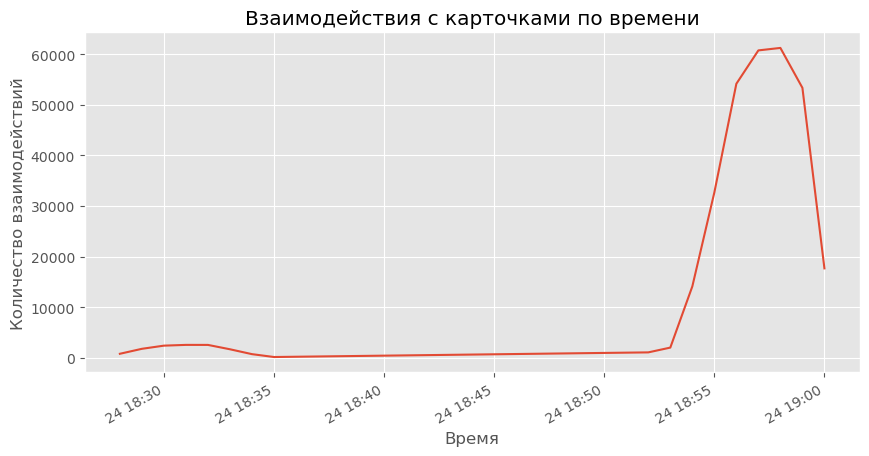

In [9]:
print('Минимальная дата:', dash_visits['dt'].min())
print('Максимальная дата:', dash_visits['dt'].max())
uniq_count('dt')
dash_visits.groupby('dt')['visits'].sum().plot(figsize=(10,5))
plt.title('Взаимодействия с карточками по времени')
plt.xlabel('Время')
plt.ylabel('Количество взаимодействий');

Имеем данные за 24.09 с 18:30 до 19:00

**visits**

In [10]:
uniq_count('visits')
dash_visits['visits'].describe()

Количество уникальных значений в visits : 212


count    30745.000000
mean        10.089673
std         19.727601
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        371.000000
Name: visits, dtype: float64

Нулевых значений нет, минимальное число визитов: 1, максимальное: 371.

**Данные выгружены корректно,** пропусков нет, столбцы хранят нужную информацию, таблица готова к работе

## Экспорт файла

In [11]:
dash_visits.to_csv(r'C:\Users\Hp\Desktop\Практикум\ДЗЕН\dash_visits.csv', index=False)

## Дашборд

Ссылка на Дашборд:

https://public.tableau.com/app/profile/.10794569/viz/__16857337719740/Dashboard

## Выводы, презентация

Выводы собраны в презентации.
Ссылка на презентацию: https://disk.yandex.ru/i/JUXOHDOWWgVrlg